## Import statements

In [75]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

from math import sqrt

Using TensorFlow backend.


## Data Collection

In [87]:
#load the dataset
df = pd.read_csv('Data4.csv')

# split into input (X) and output (Y) variables
X = df.drop('PL', axis = 1)
y = df['PL']

In [88]:
#split dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

(1750, 4)
(751, 4)


## Data Analysis and Visualization

In [66]:
#df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   28wkSlope  2501 non-null   float64
 1   48wkSlope  2501 non-null   float64
 2   WinLoss28  2501 non-null   float64
 3   WinLoss48  2501 non-null   float64
 4   PL         2501 non-null   float64
dtypes: float64(5)
memory usage: 97.8 KB


In [72]:
df.describe()

,28wkSlope,48wkSlope,WinLoss28,WinLoss48,PL
count,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000
mean,85.587404,74.567608,46.019997,45.870918,99.994222
std,343.916395,244.897840,19.793368,17.576319,1632.568624
min,-1400.170057,-1044.998508,0.000000,0.000000,-12100.000000
25%,-86.593801,-36.858174,37.500000,41.176471,-316.250000
50%,34.926544,49.882219,50.000000,50.000000,0.000000
75%,209.132458,157.961626,58.823529,57.142857,395.000000
max,1512.265326,951.331415,100.000000,78.571429,18360.000000


In [85]:
df.corr()

,28wkSlope,48wkSlope,WinLoss28,WinLoss48,PL
28wkSlope,1.000000,0.759971,0.182109,0.048741,0.008290
48wkSlope,0.759971,1.000000,0.152461,0.105655,0.005355
WinLoss28,0.182109,0.152461,1.000000,0.903670,0.027747
WinLoss48,0.048741,0.105655,0.903670,1.000000,0.014694
PL,0.008290,0.005355,0.027747,0.014694,1.000000


In [73]:
#shape of the dataset in rows,columns format
df.shape

(2501, 5)

In [67]:
#show the unique values of target variabel in ascending order
y.value_counts()

 0.00       839
-432.50       6
-10.00        6
-110.00       5
-250.00       5
           ... 
 1815.00      1
 1310.40      1
-2833.21      1
-1472.50      1
 92.50        1
Name: PL, Length: 1266, dtype: int64

In [70]:
#detect number of duplicated rows in dataset
duplicate_rows_df = df[df.duplicated()]
print(duplicate_rows_df.shape)

(35, 5)


Text(0, 0.5, 'Stocks')

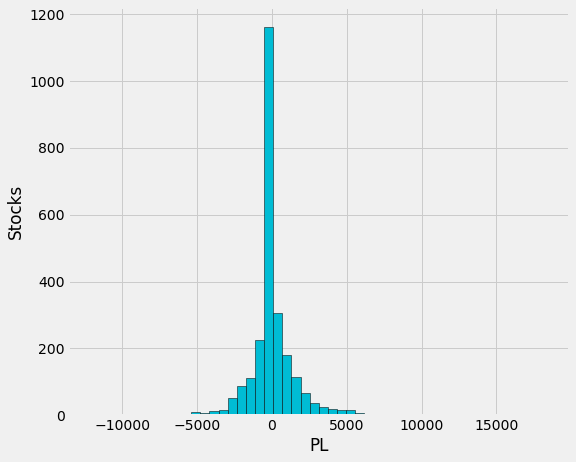

In [84]:
#plot a histogram of the target variable 'PL'
plt.figure(figsize=(8,7))
plt.hist(df['PL'], bins=50, ec='black', color='#00BCD4')
plt.xlabel('PL')
plt.ylabel('Stocks')

### Correlation and Feature Selection

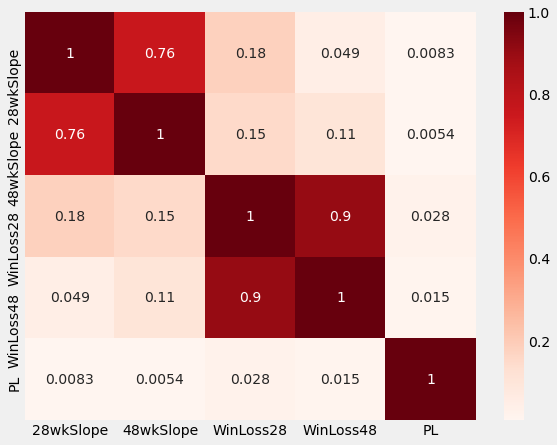

In [57]:
#Using Pearson Correlation
plt.figure(figsize=(9,7))
cor = df.corr()
#plot a heatmap of the correlation matrix
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [65]:
#Correlation of features with output variable
cor_target = abs(cor["PL"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print('Relevant features:', relevant_features)

Relevant features: PL    1.0
Name: PL, dtype: float64


### p-values and Feature Selection

In [89]:
#adding the intercept to the features 
X_incl_constant=sm.add_constant(X_train)

#call the OLS function & fit the training data to a linear regression
tmodel=sm.OLS(y_train,X_incl_constant)
results=tmodel.fit()
pd.DataFrame({'coef':results.params,'p-value':round(results.pvalues,5)})

,coef,p-value
const,177.066782,0.10465
28wkSlope,0.113115,0.54481
48wkSlope,-0.185008,0.46096
WinLoss28,6.621669,0.17701
WinLoss48,-8.337761,0.12771


In [64]:
#Feature Selection using Backward Elimination
#Remove features that have a p-value >0.05

cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print('Selected features:', selected_features_BE)

Selected features: []


### Multicollinearity and VIF

In [49]:
# VIF greater than 10 (or sometimes 5) indicates high multicollinearity
#detect VIF values of the features
vif=[variance_inflation_factor(exog=X_incl_constant.values,exog_idx=i)for i in range(X_incl_constant.shape[1])] 
pd.DataFrame({'coef_name':X_incl_constant.columns,'vif':np.around(vif,3)})

,coef_name,vif
0,const,7.658
1,28wkSlope,2.714
2,48wkSlope,2.522
3,WinLoss28,6.168
4,WinLoss48,6.068


# Linear Regression

In [90]:
#fit the training data to a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

#evaluate the model
pred_train_lr= lr.predict(X_train)
print('Training data RMSE:', np.sqrt(mean_squared_error(y_train,pred_train_lr)))
print('Training data R-Squared:', r2_score(y_train, pred_train_lr))

pred_test_lr= lr.predict(X_test)
print('Test data RMSE:', np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print('Test data R-Squared:', r2_score(y_test, pred_test_lr))

#print('Intercept', lr.intercept_)

Training data RMSE: 1646.327838628965
Training data R-Squared: 0.0021496425556236654
Test data RMSE: 1599.6039457438537
Test data R-Squared: -0.006298056930383211


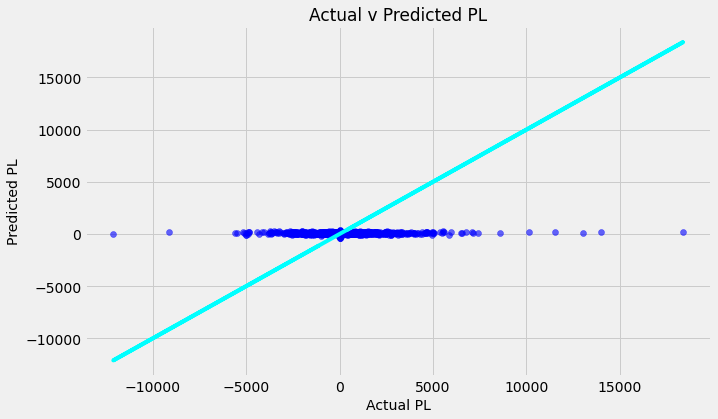

In [92]:
#plotting the predictions against the actual values
plt.figure(figsize=(10,6))
plt.scatter(x=y_train, y=results.fittedvalues, c='blue', alpha=0.6)
plt.plot(y_train,y_train,color='cyan')

plt.xlabel('Actual PL',fontsize=14)
plt.ylabel('Predicted PL',fontsize=14)
plt.title(f'Actual v Predicted PL',fontsize=17)
plt.show()

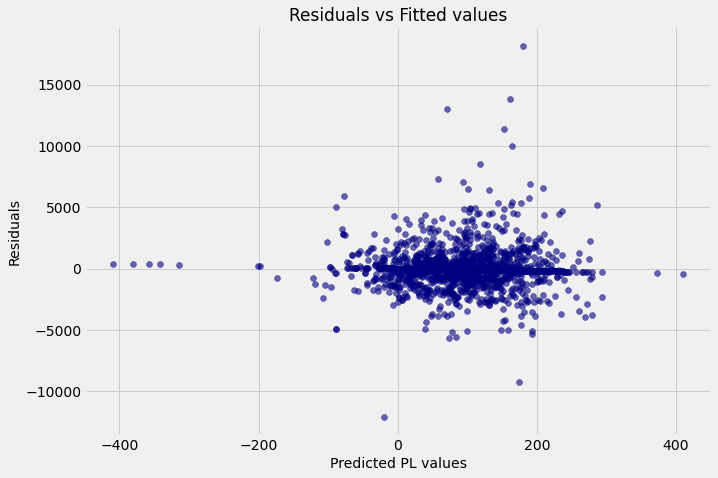

In [52]:
#Residuals vs Predicted values

plt.figure(figsize=(10,7))
plt.scatter(x=results.fittedvalues, y=results.resid, c='navy', alpha=0.6)

plt.xlabel('Predicted PL values',fontsize=14)
plt.ylabel('Residuals',fontsize=14)
plt.title('Residuals vs Fitted values',fontsize=17)
plt.show()

0.0
1.83468


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


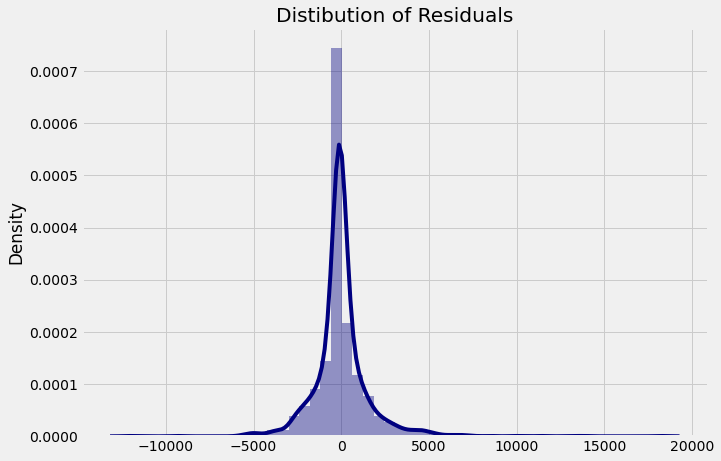

In [56]:
#Distribution of residuals - checking for normality
resid_mean=round(results.resid.mean(),5)
resid_skew=round(results.resid.skew(),5)
print(resid_mean)
print(resid_skew)
plt.figure(figsize=(10,7))
sns.distplot(results.resid, color='navy')
plt.title('Distibution of Residuals')
plt.show()

# Ridge Regression

In [16]:
#fit the training data to a ridge regression model
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train)

#evaluate the model
pred_train_rr= rr.predict(X_train)
print('Training data RMSE:', np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print('Training data R-Squared:', r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print('Test data RMSE:', np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print('Test data R-Squared:', r2_score(y_test, pred_test_rr))

Training data RMSE: 1646.327838628965
Training data R-Squared: 0.0021496425556236654
Test data RMSE: 1599.603945496788
Test data R-Squared: -0.006298056619529202


# Lasso Regression

In [17]:
#fit the training data to a lasso regression model
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 

#evaluate the model
pred_train_lasso= model_lasso.predict(X_train)
print('Training data RMSE:', np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print('Training data R-Squared:', r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print('Test data RMSE:', np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print('Test data R-Squared:', r2_score(y_test, pred_test_lasso))

Training data RMSE: 1646.327838630963
Training data R-Squared: 0.002149642553201714
Test data RMSE: 1599.6038877709263
Test data R-Squared: -0.006297983989774103


# Random Forest Regression

In [93]:
#fit the training data to a random forest regression model
rf = RandomForestRegressor(n_estimators = 700, random_state = 42)
rf.fit(X_train, y_train);

#evaluate the model
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
print("Test data RMSE: %.2f" % np.sqrt(mean_squared_error(y_test,predictions)))

Test data RMSE: 1747.38


ymin: -8890.0 ymax: 8823.0


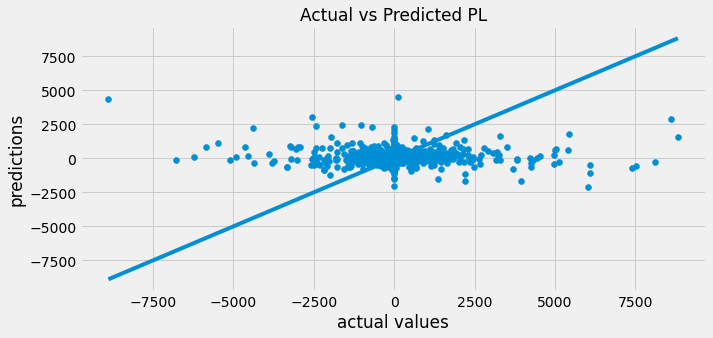

In [98]:
#plotting the predictions against the actual values    
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.scatter(y_test, predictions)
plt.xlabel("actual values")
plt.ylabel("predictions")
plt.title(f'Actual vs Predicted PL',fontsize=17)
ymin = np.round( min( min(y_test), min(predictions) ) )
ymax = np.ceil( max( max(y_test), max(predictions) ) )
print("ymin:", ymin, "ymax:", ymax)
r = range(int(ymin), int(ymax) + 1)
plt.plot(r, r)

In [23]:
# Get numerical feature importances
feature_list = list(X.columns)
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: 48wkSlope            Importance: 0.39
Variable: 28wkSlope            Importance: 0.35
Variable: WinLoss48            Importance: 0.14
Variable: WinLoss28            Importance: 0.12


# Neural Network Regression (Keras Deep Learning)

In [76]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [99]:
# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X, y, cv=kfold)

In [112]:
#print("Cross validation score: %.2f " % (results.mean()))
#print('Test data RMSE:', np.sqrt(results.std()))
print("Baseline: %.2f (%.2f) RMSE" % (np.sqrt(abs(results.mean())), np.sqrt(results.std())))

Baseline: 1636.59 (1283.70) RMSE
